# PACE L2 for AVUELO

In [1]:
# Load Modules
import earthaccess
import xarray as xr
from xarray.backends.api import open_datatree
import matplotlib.pyplot as plt
import cartopy
import numpy as np
import h5netcdf
from IPython.display import JSON
import geopandas as gpd
from shapely.geometry import Point, LineString
import re
import pandas as pd
import seaborn as sns

In [2]:
# Authentification
auth = earthaccess.login(persist=True)

Enter your Earthdata Login username:  m11keluis
Enter your Earthdata password:  ········

Enter your Earthdata password:  ········


## PACE: Level 2 - BGC

In [3]:
# PACE Search Criteria
tspan = ("2025-02-18", "2025-02-18")
bbox=(-84.951187, 9.645435, -84.653903, 9.954900)

# Search for PACE Imagery
results = earthaccess.search_data(
    short_name="PACE_OCI_L2_BGC_NRT",
    temporal=tspan,
    bounding_box=bbox,
)

# Pull from Cloud
paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
paths

[<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20250218T183457.L2.OC_BGC.V3_0.NRT.nc>]

In [ ]:
# Functions 
def process_l2(path):
    
    prod = xr.open_dataset(path)
    obs = xr.open_dataset(path, group="geophysical_data")
    nav = xr.open_dataset(path, group="navigation_data")
    nav = (
        nav
        .set_coords(("longitude", "latitude"))
    )
    dataset = xr.merge((prod, obs, nav.coords))

    return dataset

In [ ]:
# Chlorophyll 
dataset = process_l2(paths[0])
array = np.log10(dataset["chlor_a"])
array.attrs.update(
    {
        "units": f'log10({dataset["chlor_a"].attrs["units"]})',
    }
)

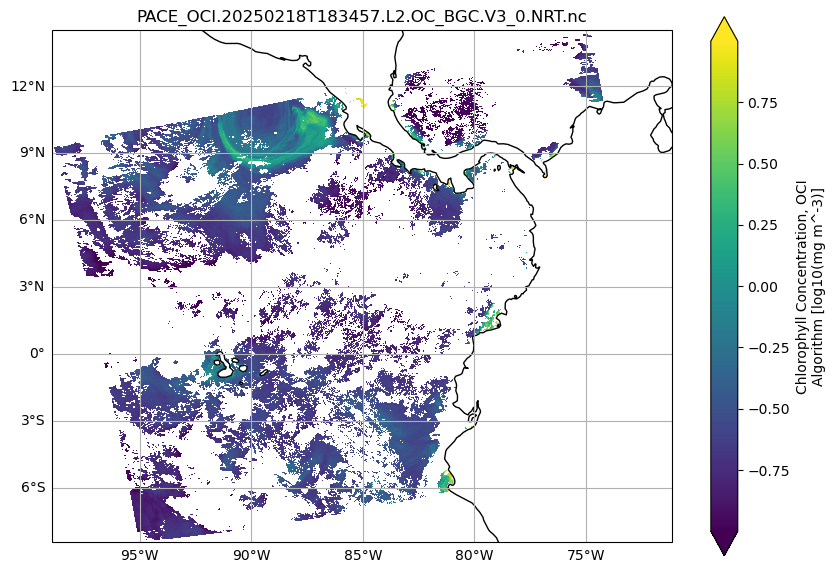

In [7]:
# Full PACE Image
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection=cartopy.crs.PlateCarree())
array.plot(x="longitude", y="latitude", cmap="viridis", robust=True, ax=ax)
ax.coastlines()
ax.gridlines(draw_labels={"bottom": "x", "left": "y"})
ax.set_title(dataset.attrs["product_name"], loc="center")
plt.show()

In [8]:
# PACE Subset
S = 7.671779
N = 10.511562
W = -86.225062
E = -82.295758

# Chlorophyll Box 
chl_box = np.log(dataset["chlor_a"]).where(
    (
        (dataset["latitude"] > S)
        & (dataset["latitude"] < N)
        & (dataset["longitude"] > W)
        & (dataset["longitude"] < E)
    ),
    drop=True,
)
chl_box.attrs.update(
    {
        "units": f'log10({dataset["chlor_a"].attrs["units"]})',
    }
)

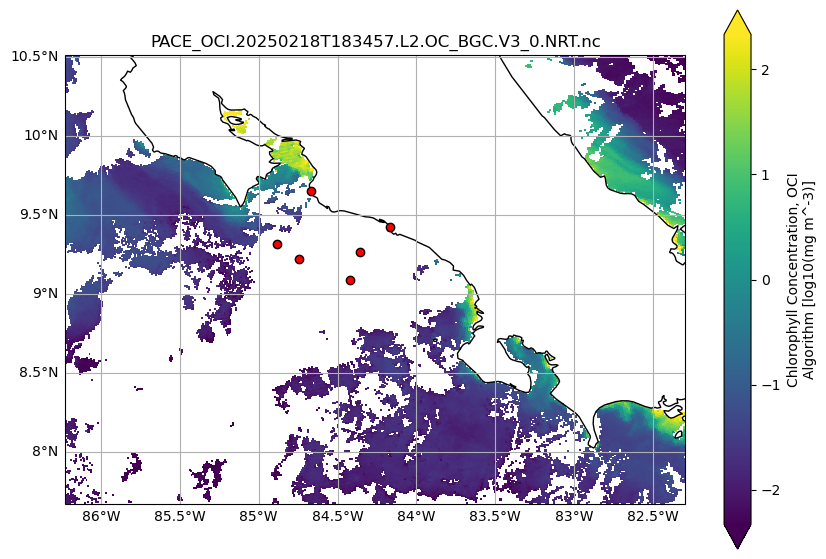

In [14]:
# Plot PACE Chlorophyll and Boat Locations
import cartopy.crs as ccrs

fig = plt.figure(figsize=(10, 7))

ax = plt.axes(projection=cartopy.crs.PlateCarree())
chl_box.plot(x="longitude", y="latitude", cmap="viridis",
             robust=True, ax=ax)
ax.coastlines()
ax.gridlines(draw_labels={"bottom": "x", "left": "y"})
ax.set_title(dataset.attrs["product_name"], loc="center")

# Day 2 Stations
day2_sites = {'Los Suenos': {'lon':-84.667000, 'lat':9.650000},
            'Hermosa Offshore': {'lat': 9.31520, 'lon': -84.884600},
             'Parrita Offshore': {'lat': 9.224700, 'lon': -84.746800},
              'Savegre Offshore': {'lat': 9.090600, 'lon':-84.418100},
             'Quepos Offshore': {'lat': 9.268200, 'lon': -84.357100},
             'Pez Vela': {'lat': 9.426600, 'lon': -84.168900}}


for site, coords in day2_sites.items():
    ax.plot(coords['lon'], coords['lat'], marker='o', color='red', markersize=6, markeredgecolor='black', markeredgewidth=1, transform=ccrs.PlateCarree())
    #ax.text(coords['lon'] + 0.01, coords['lat'] - 0.015, site, fontsize=10, transform=ccrs.PlateCarree()

ax.set_extent([W, E, S, N], crs=ccrs.PlateCarree())

fig.savefig('figures/' + dataset.attrs["product_name"] + '.png', dpi=600)